# Numerically Controlled Oscillator (NCO)
This notebook is used to develop the NCO which will later be developed in hardware

### Install Dependencies:

In [2]:
pip install matplotlib numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Parameters

In [184]:
import numpy as np
import math
import matplotlib.pyplot as plt

FS = 48000 # sample rate
N_PA = 32 # phase accumulator bit width
N_SR = 24 # sample rate bit width
MIDI_RANGE = 128 # MIDI takes value x, {0≤x≤127}
A4 = 69 # note A4 is the 69th note (440Hz)

### Calculate Word Values
The mathematical equation that relates the output frequency (Fout​) of a DDS synthesizer to the tuning word (M) is given by:

$F_{out}=\frac{M⋅F_{s}}{2^n}$

##### frequency derivation
$f(n) = 440\cdot2^{\frac{n-69}{12}}$
A4 (440Hz) is the 69th note

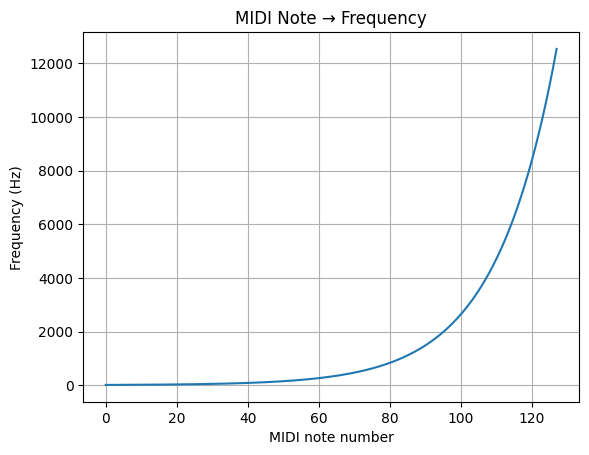

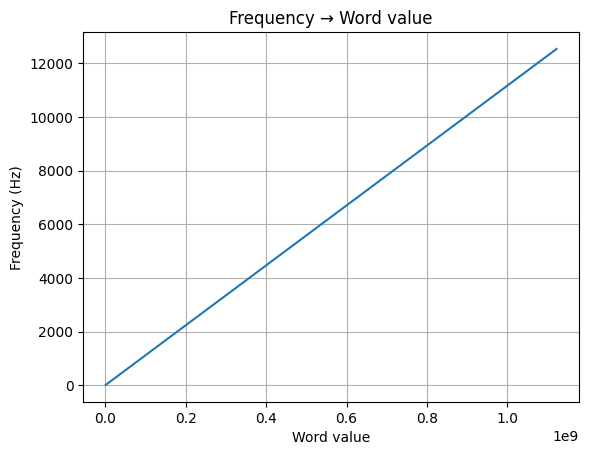

In [185]:
notes = np.arange(MIDI_RANGE)
note_freqs = 440.0 * (2.0 ** ((notes - 69) / 12.0))

pa_words = np.round((note_freqs / FS) * (1 << N_PA)).astype(np.uint32)

# plot midi note to frequency
notes = np.arange(len(note_freqs))
plt.figure()
plt.plot(notes, note_freqs)
plt.xlabel("MIDI note number")
plt.ylabel("Frequency (Hz)")
plt.title("MIDI Note → Frequency")
plt.grid(True)
plt.show()

# plot frequency to word value
plt.figure()
plt.plot(pa_words, note_freqs)
plt.xlabel("Word value")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency → Word value")
plt.grid(True)
plt.show()

### Naive Look-Up Table (LUT) Construction
The following table uses a sine wave. The values stored in the table are given by:
$y_k = sin(2\pi k/N)$ where k is an intger between 0 and N where N is $2^{N\_LUT}$

THE LUTs below for the saw, triangle and square are naive implmenetations as they will not perform well at higher octaves due to increased harmonic content in the higher range. This problem will be solved later by implementing *additive synthesis* for generating these LUTs

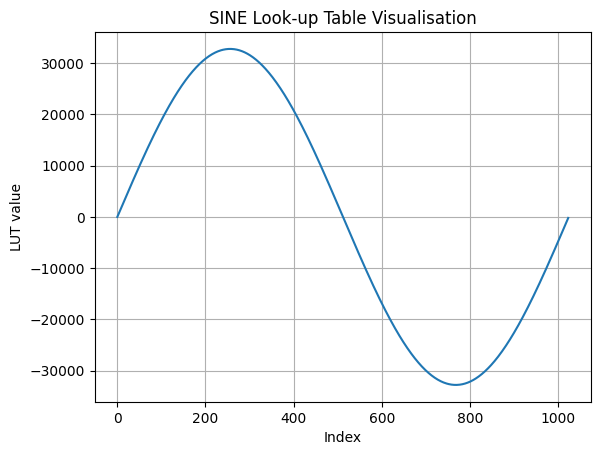

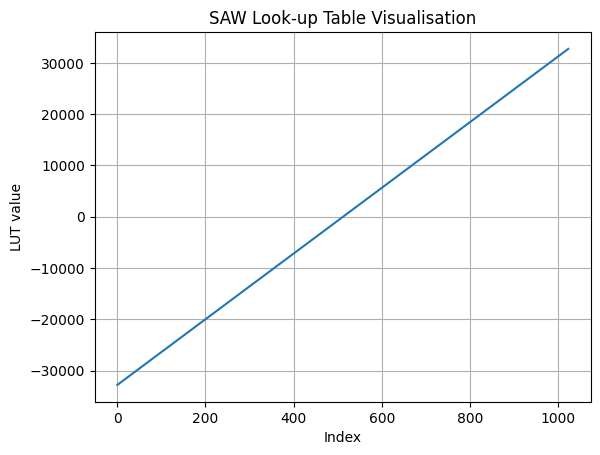

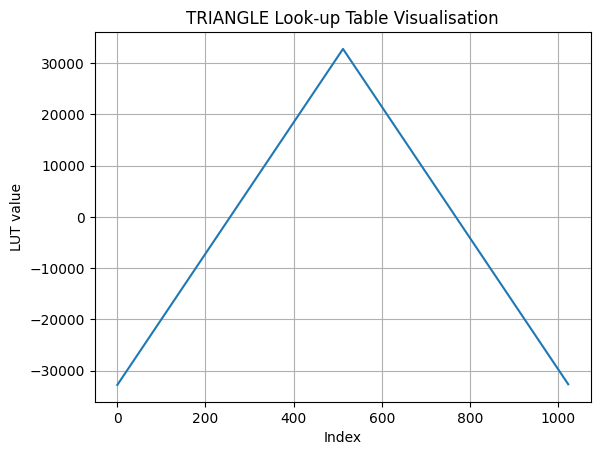

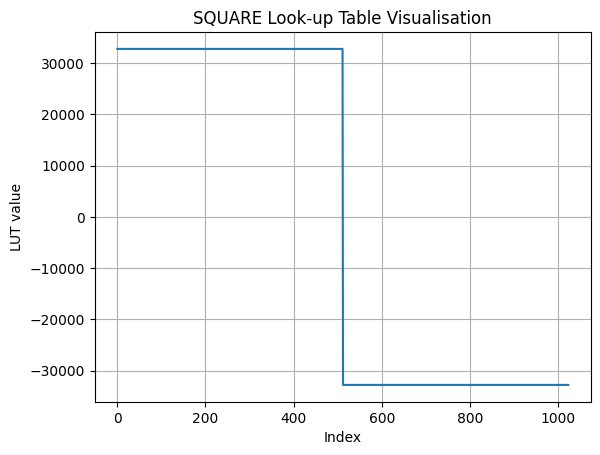

In [138]:
N_LUT = 10 # lookup table bit width (1024 entries)
LUT_LEN = 1 << N_LUT
AMP_BITS = 15  

# SINE WAVE LUT
sin_lut = np.round(
    np.sin(2 * np.pi * np.arange(LUT_LEN) / LUT_LEN)
    * (1 << AMP_BITS)
).astype(np.int32)
# LUT values need to be scaled so that they can be stored as integers to avoid floating point arithmetic

# SAW TOOTH WAVE LUT
saw_lut = np.round(
    (2.0 * (np.arange(LUT_LEN) / LUT_LEN) - 1.0) 
    * (1<<AMP_BITS)
).astype(np.int32)

# TRIANGLE WAVE LUT
k = np.arange(LUT_LEN, dtype=np.float64)
phase_f = k / LUT_LEN
triangle = 1.0 - 4.0 * np.abs(phase_f - 0.5)
triangle_lut = np.round(triangle * (1<<AMP_BITS)).astype(np.int32)

# SQUARE WAVE LUT
first_half = (np.zeros(LUT_LEN // 2) + 1.0)
second_half = (np.zeros(LUT_LEN // 2) - 1.0)
square_lut = np.round(
    np.concatenate((first_half,second_half)) * (1<<AMP_BITS)
).astype(np.int32)

plt.figure()
plt.plot(np.arange(LUT_LEN), sin_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SINE Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), saw_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SAW Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), triangle_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("TRIANGLE Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), square_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SQUARE Look-up Table Visualisation")
plt.grid(True)
plt.show()

/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_46328/92520652.py:12: RuntimeWarning: overflow encountered in scalar add
  phase[i] = (phase[i-1] + pa_words[A4 + 12]) & mask


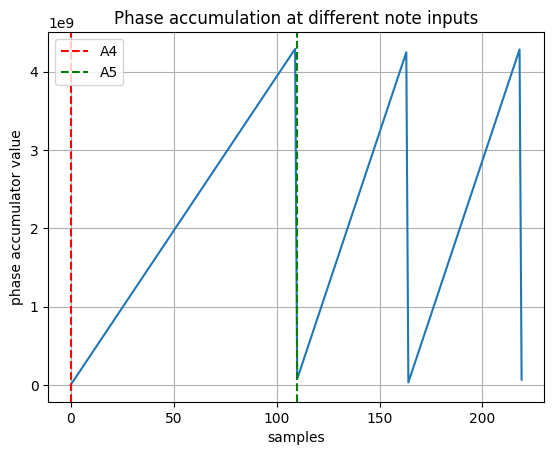

In [145]:
### Phase accumulator
NUM_SAMPLES = 220
phase = np.zeros(NUM_SAMPLES, dtype=np.uint32)

mask = (1 << N_PA) - 1
half = NUM_SAMPLES // 2

for i in range(1, half):
    phase[i] = (phase[i-1] + pa_words[A4]) & mask

for i in range(half, NUM_SAMPLES):
    phase[i] = (phase[i-1] + pa_words[A4 + 12]) & mask

# plot phase accumulator
plt.figure()
plt.plot(np.arange(NUM_SAMPLES), phase)
plt.xlabel("samples")
plt.ylabel("phase accumulator value")
plt.axvline(x=0, color='r', linestyle='--', label='A4')
plt.axvline(x=NUM_SAMPLES//2, color='g', linestyle='--', label='A5')
plt.title("Phase accumulation at different note inputs")
plt.grid(True)
plt.legend()
plt.show()


### Matching Phase Accumulator value to LUT entry
In the event that the phase accumulator word size is larger than the bit width of the lookup table, we will have to bit shift the PA word $(N\_PA-N\_LUT)$ bits right in order to index into the table correctly. This operation always rounds down the PA value.

In order to increase the pitch output accuracy, linear interpolation can be used. As we always round down, we can use the last $(N\_PA-N\_LUT)$ bits of the PA word to determine how far we are between the LUT index, $i$, as selected by the first $N\_LUT$ bits and LUT index $i+1$

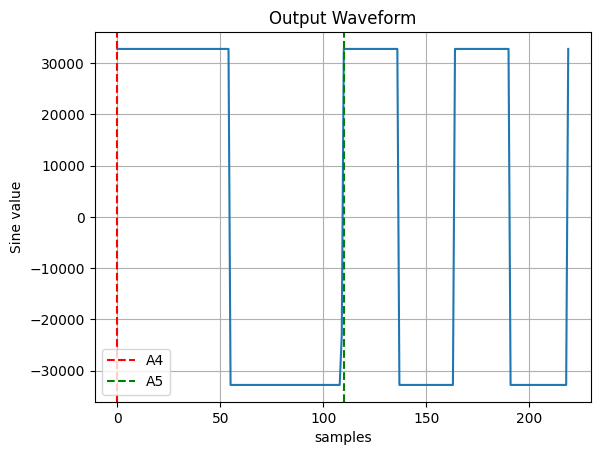

In [146]:
#phase_accumulator>>(N_PA-N_LUT) #Left with N_LUT bits. We always truncate (round down) - check the next lut value for linear interpolation

#output_waveform = sin_lut

N_FRAC = 10 # use 10 bit accuracy

def lin_interp(lower_index, frac_index, N_FRAC, lut):
    lower = lut[lower_index]
    upper = lut[(lower_index+1) & (len(lut)-1)] # wrap if out of bounds

    diff = upper - lower
    return lower + ((diff * frac_index) >> N_FRAC)

shift_index = N_PA - N_LUT
shift_frac  = N_PA - N_LUT - N_FRAC

idx  = (phase >> shift_index).astype(np.uint32)
frac = ((phase >> shift_frac) & ((1 << N_FRAC) - 1)).astype(np.uint32)

out = np.zeros(NUM_SAMPLES, dtype=np.int32)
for i in range(NUM_SAMPLES):
    out[i] = lin_interp(int(idx[i]), int(frac[i]), N_FRAC, square_lut)


plt.figure()
plt.plot(np.arange(NUM_SAMPLES), out)
plt.xlabel("samples")
plt.ylabel("Sine value")
plt.title("Output Waveform")
plt.axvline(x=0, color='r', linestyle='--', label='A4')
plt.axvline(x=NUM_SAMPLES//2, color='g', linestyle='--', label='A5')
plt.grid(True)
plt.legend()
plt.show()


### Additively Generated Bandwidth-Limited LUTs

We will need to use multiple tables for each waveform. Standard practice is to create one LUT for each octave.

$K_{max}=\frac{F_s/2}{f_{hi}}$

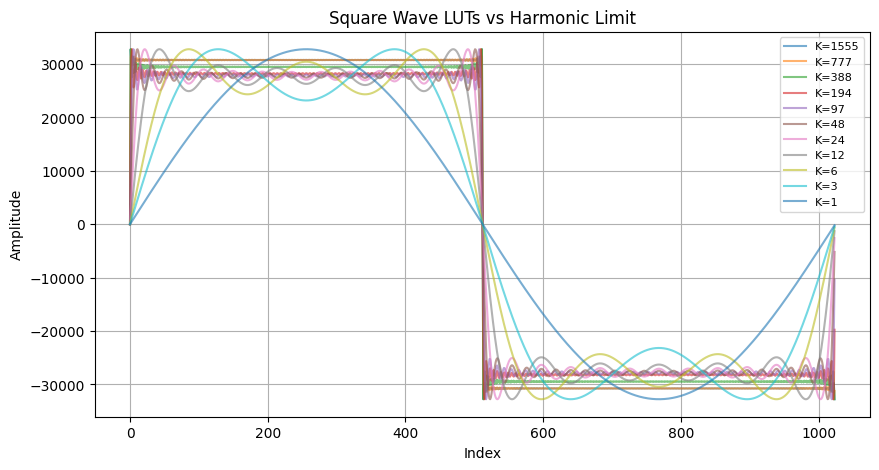

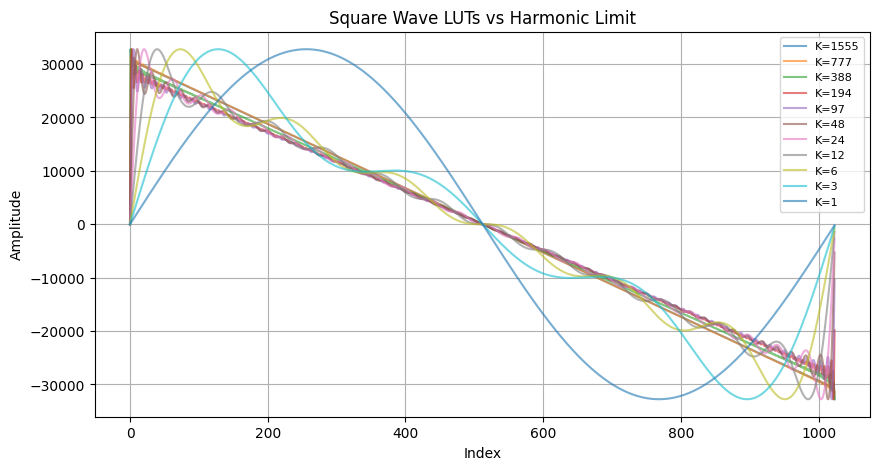

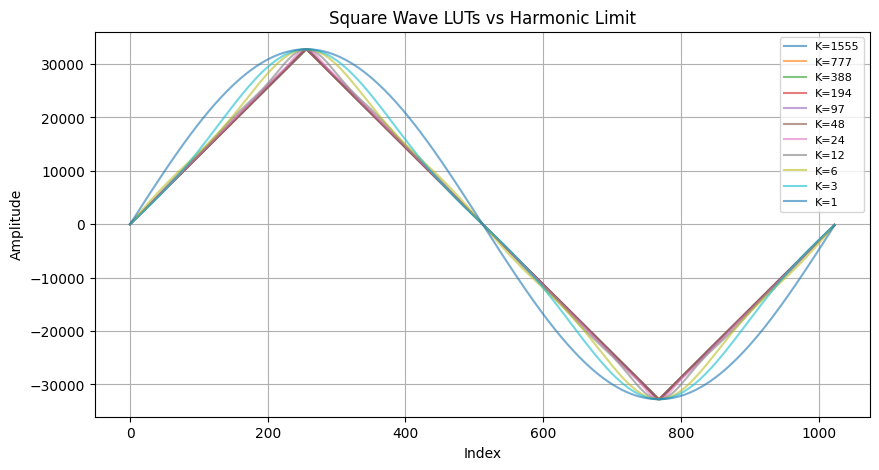

In [231]:
NOTES_PER_BAND = 12

BANDS = np.int16(math.ceil((MIDI_RANGE/NOTES_PER_BAND)))
K_maximums = np.zeros(BANDS, dtype=np.int32)

for i in range(BANDS):
    hi_note = min((i+1)*NOTES_PER_BAND - 1, MIDI_RANGE - 1)  
    K_maximums[i] = int((FS/2) // note_freqs[hi_note])

def generate_square_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1, 2) # odd harmonics
        coeffs = 1.0 / ks                   

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(x)
    return luts

def generate_saw_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1)
        coeffs = 1.0 / ks

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(x)
    return luts

def generate_triangle_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1, 2)
        signs = (-1)**((ks-1)//2)
        coeffs = signs/(ks**2)

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(x)
    return luts

square_luts = generate_square_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)
saw_luts = generate_saw_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)
triangle_luts = generate_triangle_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)

j = 8 # arbitraty index for plotting

### SQUARE
plt.figure(figsize=(10, 5))

for i, lut in enumerate(square_luts):
    K = K_maximums[i]
    plt.plot(lut, alpha=0.6, label=f"K={K}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Square Wave LUTs vs Harmonic Limit")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

### SAW
plt.figure(figsize=(10, 5))

for i, lut in enumerate(saw_luts):
    K = K_maximums[i]
    plt.plot(lut, alpha=0.6, label=f"K={K}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Square Wave LUTs vs Harmonic Limit")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

### TRIANGLE
plt.figure(figsize=(10, 5))

for i, lut in enumerate(triangle_luts):
    K = K_maximums[i]
    plt.plot(lut, alpha=0.6, label=f"K={K}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Square Wave LUTs vs Harmonic Limit")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()
